In [1]:
from openquantumcomputing import QAOAPortfolioOptimization, QAOABase
from openquantumcomputing import Statistic
import asset_loader

from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
from tqdm import tqdm
import itertools


from importlib import reload

c:\Users\havardh\playground-win\quantumComputing\optimization\PortfolioOptimization\asset_loader.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


64


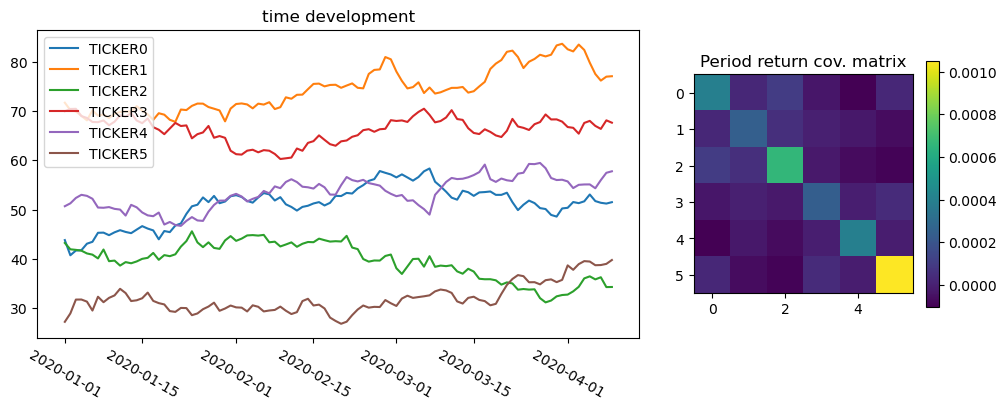

In [2]:
reload(asset_loader)
assets = asset_loader.AssetData(6, 100, seed=13)
assets.plotAssets()

params = {
    "risk" : 0.5,
    "budget": 2,
    "penalty": 4,
    "cov_matrix": assets.cov_matrix,
    "exp_return": assets.exp_return,
    "usebarrier": True
}
print(2**assets.N)

In [3]:
reload(QAOAPortfolioOptimization)
qaoa_portopt = QAOAPortfolioOptimization.QAOAPortfolioOptimization(params)

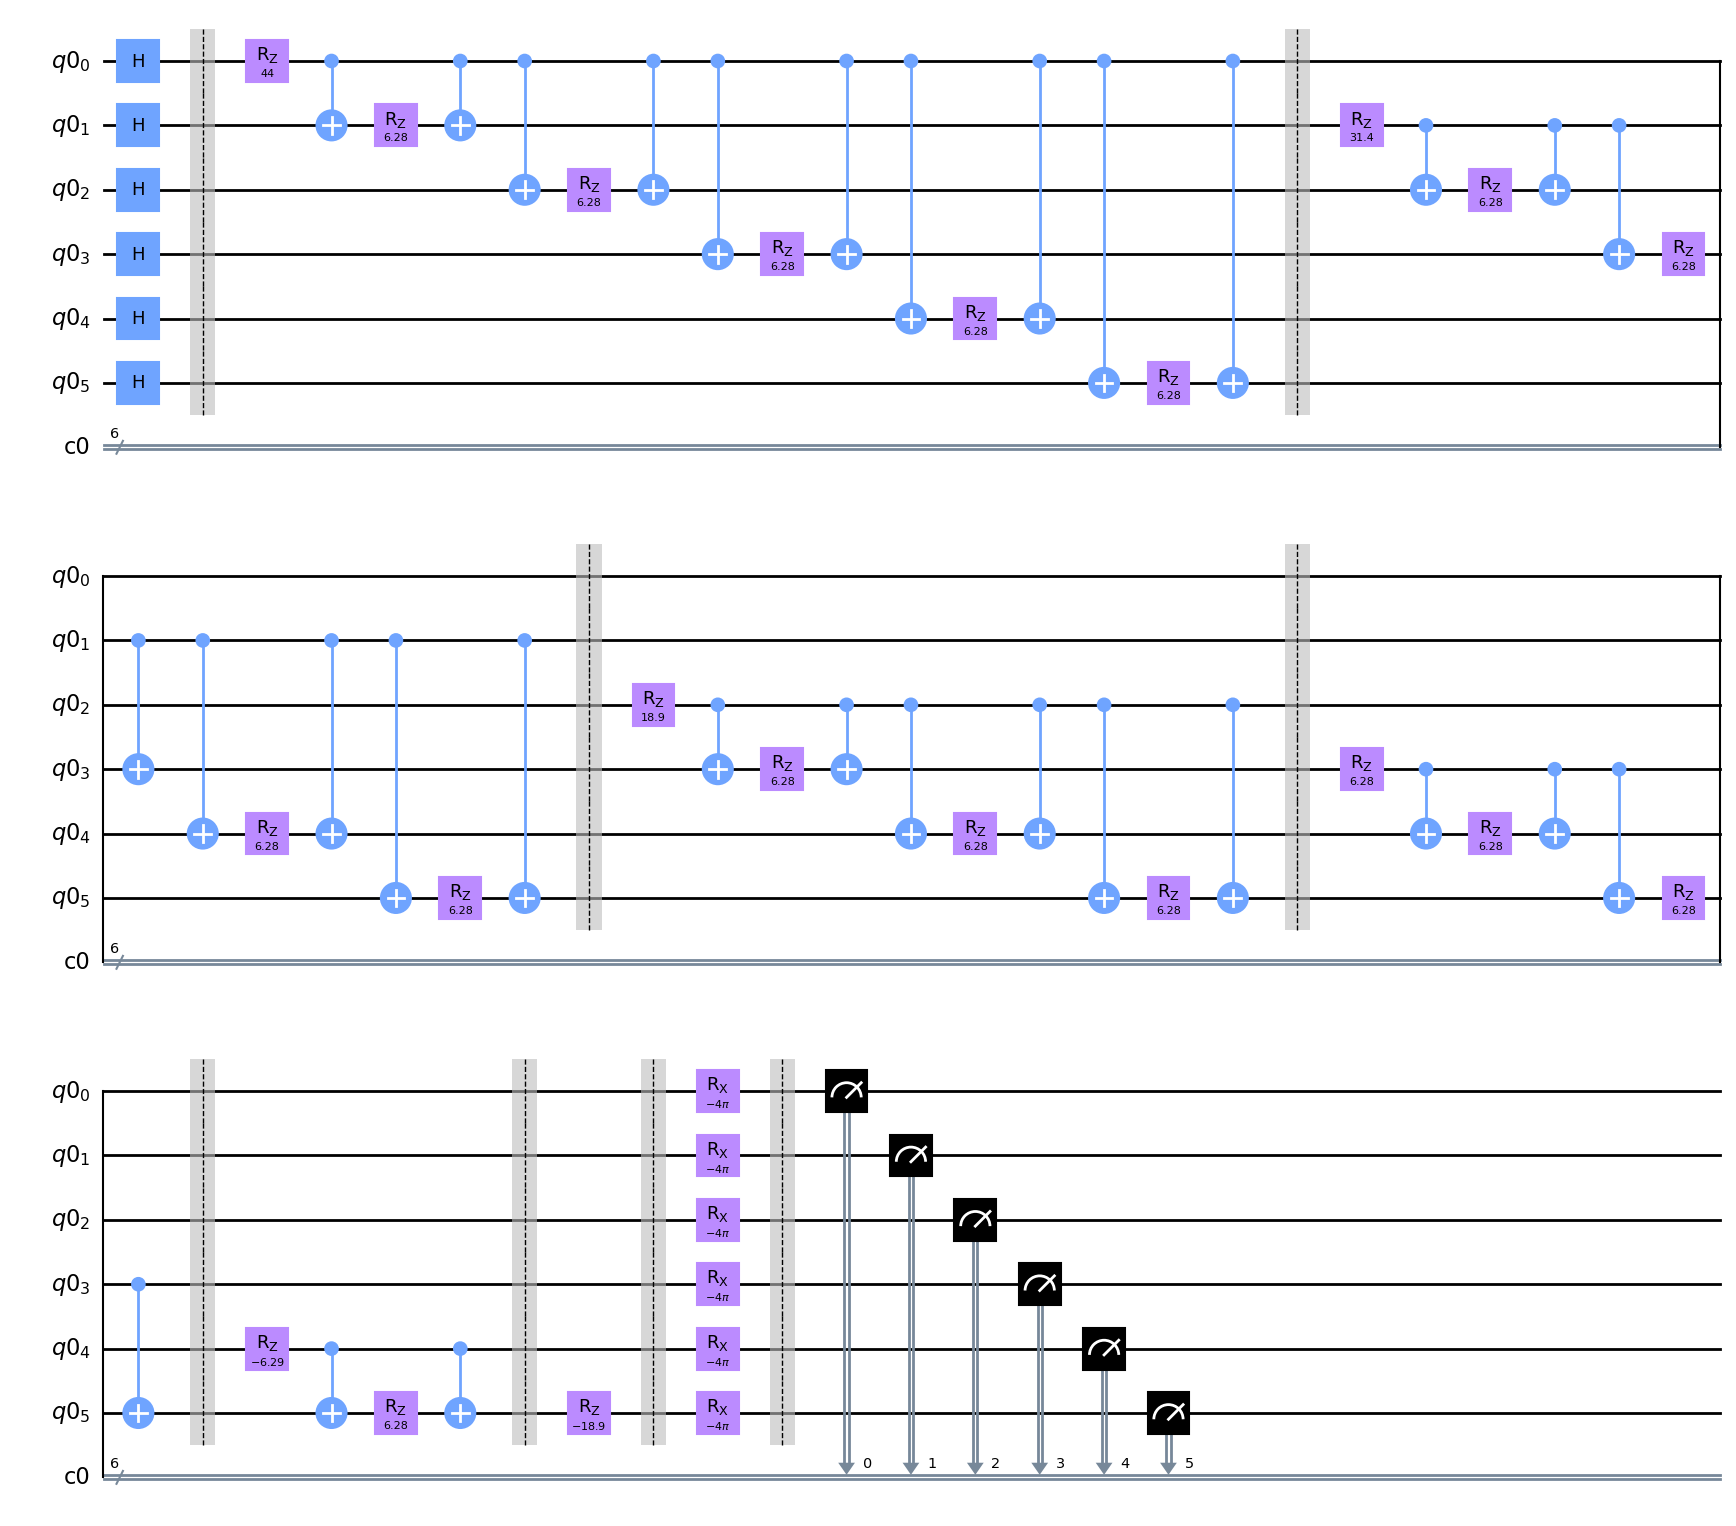

In [4]:
display(qaoa_portopt.createCircuit(np.array((np.pi,2*np.pi)),1).draw(output='mpl'))


In [5]:

print("solutions:")
best_sol = None
best_cost = None
for s in [''.join(i) for i in itertools.product('01', repeat = assets.N)]:
    c = qaoa_portopt.cost(s)
    if best_sol is None:
        best_sol = s
        best_cost = c
    elif c > best_cost:
        best_sol = s
        best_cost = c

    if qaoa_portopt.isFeasible(s):
        print(s, c)
    else: 
        print(s, '\t', c)

print("--------------------")
print("Best sol is "+ best_sol + " with cost " + str(best_cost))

solutions:
000000 	 -16.0
000001 	 -3.9961826539466863
000010 	 -3.998681291258883
000011 0.005149285769853407
000100 	 -4.000341395451567
000101 0.0034369571369659013
000110 0.000982559034333974
000111 	 -3.9952258574017137
001000 	 -4.002333065994415
001001 0.0015792261027094412
001010 -0.0009441163260390795
001011 	 -3.9970185932535003
001100 -0.0026484871652812103
001101 	 -3.998775188532939
001110 	 -4.001254291752133
001111 	 -15.997367762144364
010000 	 -3.9992716588144965
010001 0.0046114172079469995
010010 0.0020760282873837355
010011 	 -3.99402766471475
010100 0.00039152639381967447
010101 	 -3.9957643910485174
010110 	 -3.9982555407595157
010111 	 -15.994398227226426
011000 -0.0016550158624220046
011001 	 -3.9976769937961762
011010 	 -4.000237087833291
011011 	 -15.996245834791608
011100 	 -4.001965856373403
011101 	 -15.998026827771938
011110 	 -16.000542682599487
011111 	 -35.996590423022596
100000 	 -3.998367003059391
100001 0.005428075404783073
100010 0.00305634244103458

## Sample cost landscape

In [6]:
qasm_sim = Aer.get_backend('qasm_simulator')

In [7]:
qaoa_portopt.sample_cost_landscape(qasm_sim, 1024, angles={"gamma": [0,np.pi,50], "beta": [0,np.pi,40]})

Calculating Energy landscape for depth p=1...
Calculating Energy landscape done


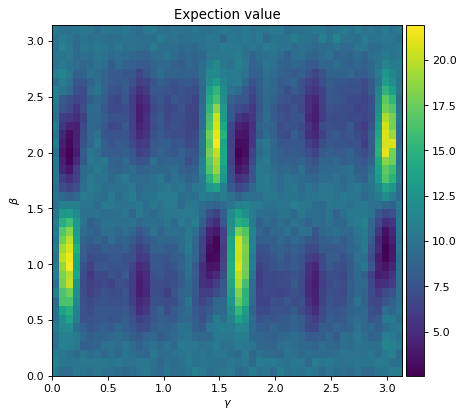

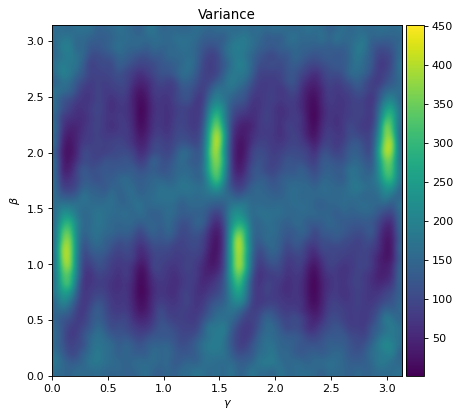

In [8]:
def plotLandscape(field, title, interpolation='bicubic'):
    f = plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
    _=plt.xlabel(r'$\gamma$')
    _=plt.ylabel(r'$\beta$')
    ax = plt.gca()
    _=plt.title(title)
    im = ax.imshow(field, interpolation=interpolation, origin='lower', extent=[0,np.pi,0,np.pi])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _=plt.colorbar(im, cax=cax)

plotLandscape(qaoa_portopt.E, "Expection value", interpolation="None")
#plotLandscape(qaoa_portopt.E, r'CVaR with $\alpha$='+str(qaoaec_cvar.params["alpha"])) #, interpolation="None")
plotLandscape(qaoa_portopt.Var, "Variance")


In [9]:
maxdepth=10
for i in tqdm(range(maxdepth)):
    qaoa_portopt.increase_depth(qasm_sim, 1024)

 10%|█         | 1/10 [00:01<00:17,  1.96s/it]

cost(depth= 1 )= 2.5829933609362214


 20%|██        | 2/10 [00:03<00:12,  1.58s/it]

cost(depth= 2 )= 6.725234989402634


 30%|███       | 3/10 [00:06<00:15,  2.23s/it]

cost(depth= 3 )= 6.611086736425675


 40%|████      | 4/10 [00:10<00:17,  2.86s/it]

cost(depth= 4 )= 7.356770721480401


 50%|█████     | 5/10 [00:14<00:16,  3.39s/it]

cost(depth= 5 )= 6.259591530955283


 60%|██████    | 6/10 [00:20<00:17,  4.41s/it]

cost(depth= 6 )= 5.828438714146477


 70%|███████   | 7/10 [00:30<00:18,  6.13s/it]

cost(depth= 7 )= 2.864840185559787


 80%|████████  | 8/10 [00:42<00:15,  7.91s/it]

cost(depth= 8 )= 2.673134117383907


 90%|█████████ | 9/10 [00:57<00:10, 10.21s/it]

cost(depth= 9 )= 3.143092114770156


100%|██████████| 10/10 [01:14<00:00,  7.41s/it]

cost(depth= 10 )= 6.161788672015834


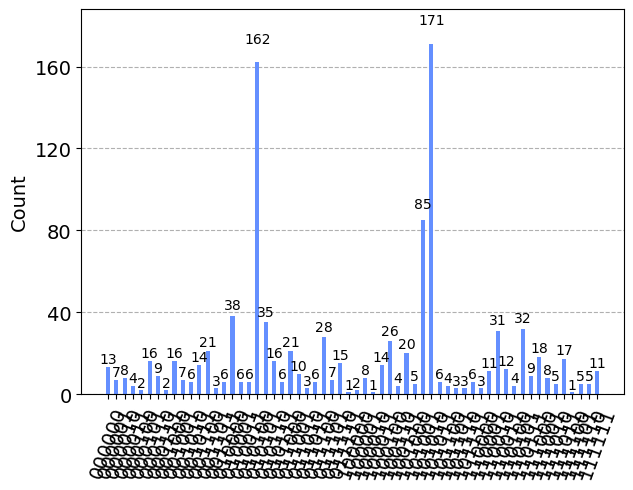

In [10]:
hist=qaoa_portopt.hist(qaoa_portopt.angles_hist['d'+str(maxdepth)+'_final'], qasm_sim,1024)
plot_histogram(hist)

In [11]:
sorted_hist = dict(sorted(hist.items(), key=lambda item: item[1], reverse=True))

print("Classical best result: ", (best_sol, best_cost))

i = 0
for s, freq in sorted_hist.items():
    if i > 20:
        break
    if s == best_sol:
        print(str(i)+" -->\t", qaoa_portopt.cost(s), s, freq)
    elif qaoa_portopt.isFeasible(s):
        print(str(i)+"\t", qaoa_portopt.cost(s), s, freq)
    else:
        print(str(i)+"\t\t", qaoa_portopt.cost(s), s, freq)
    i = i + 1



Classical best result:  ('100001', 0.005428075404783073)
0		 -3.9993061575996975 101010 171
1	 0.00039152639381967447 010100 162
2		 -3.996909719519401 101001 85
3		 -3.9992716588144965 010000 38
4		 -3.9957643910485174 010101 35
5		 -15.994141359638306 110101 32
6		 -3.9962095025825803 110010 31
7		 -4.001965856373403 011100 28
8	 0.0013270681176713595 100100 26
9	 -0.0016550158624220046 011000 21
10	 -0.0026484871652812103 001100 21
11		 -15.993475024662288 100111 20
12		 -4.0001448584652906 111000 18
13		 -35.994653308224315 111011 17
14		 -3.9982555407595157 010110 16
15	 0.0034369571369659013 000101 16
16		 -4.002333065994415 001000 16
17		 -16.000542682599487 011110 15
18		 -3.9970185932535003 001011 14
19		 -3.9931353481193668 100011 14
20		 -16.0 000000 13


In [12]:
def cost(qaoa_portopt, string, penalize=True):
        
        risk       = qaoa_portopt.params.get("risk")
        budget     = qaoa_portopt.params.get("budget")
        cov_matrix = qaoa_portopt.params.get("cov_matrix")
        exp_return = qaoa_portopt.params.get("exp_return")
        penalty    = qaoa_portopt.params.get("penalty", 0.0)

        x = np.array(list(map(int,string)))        
        cost = risk* (x.T@cov_matrix@x) - exp_return.T@x
        if penalize:
            cost += penalty * (x.sum() - budget)**2

        return -cost


for s in ["111111", "000000", "010101", "011000", "010001"]:
    print(cost(qaoa_portopt, s), qaoa_portopt.cost(s), qaoa_portopt.cost_nonQUBO(s))





-63.99496242982665 -63.99496242982666 -63.99496242982665
-16.0 -16.0 -16.0
-3.995764391048522 -3.9957643910485174 -3.995764391048522
-0.0016550158624250885 -0.0016550158624220046 -0.0016550158624250885
0.004611417207942098 0.0046114172079469995 0.004611417207942098
